In [7]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [8]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

In [9]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
  "PlantVillage",
    shuffle=True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [10]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [11]:
len(dataset)

68

In [12]:
68 * 32

2176

In [13]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[1 1 0 0 1 2 1 0 0 1 1 0 0 0 1 1 1 2 1 1 1 1 1 1 1 1 1 0 1 1 0 0]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)


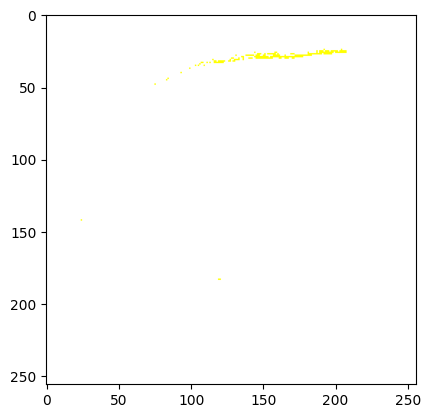

In [14]:
for image_batch, label_batch in dataset.take(1):
    plt.imshow(image_batch[0].numpy())
    print(image_batch[0].shape)

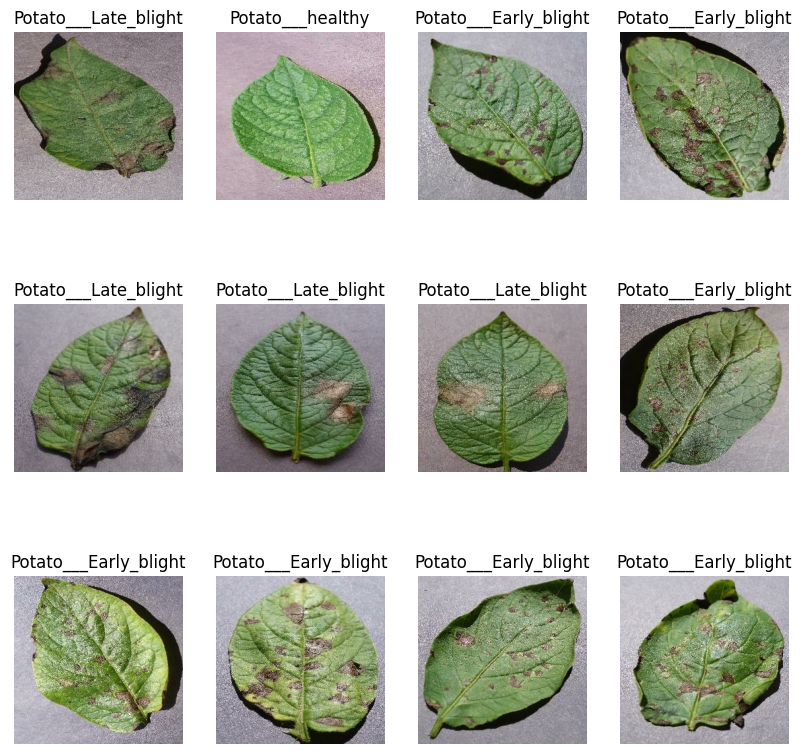

In [15]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        #print(image_batch.shape)
        #print(label_batch.numpy())
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [16]:
len(dataset)

68

In [17]:
80% ==> training
20% ==> 10% validation , 10% test

SyntaxError: invalid syntax (3470375362.py, line 1)

In [18]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [19]:
train_ds = dataset.take(54)
len(train_ds)

54

In [20]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [21]:
val_size = 0.1
len(dataset)*val_size

6.800000000000001

In [22]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [23]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [24]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed  = 12)
        
    train_size = int(train_split*ds_size)
    val_size = int(val_split*ds_size)
    
    train_ds = ds.take(train_size)
    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)
    return train_ds, val_ds, test_ds


In [25]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [26]:
len(train_ds)

54

In [27]:
len(val_ds)

6

In [28]:
len(test_ds)

8

In [29]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [30]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Rescaling(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [31]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
    
])

In [32]:
input_shape = (BATCH_SIZE,IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model= models.Sequential ([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3), activation = 'relu', input_shape = (IMAGE_SIZE, IMAGE_SIZE)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size= (3,3), activation ='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size= (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation = 'relu'),
    layers.Dense(n_classes, activation = 'softmax'),
    
])

model.build(input_shape = input_shape)

In [33]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [39]:
model.compile(
    optimizer='adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy']
)

In [40]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=10,
)

Epoch 1/10
54/54 [==============================] - 177s 3s/step - loss: 0.2719 - accuracy: 0.9010 - val_loss: 0.3816 - val_accuracy: 0.8854
Epoch 2/10
54/54 [==============================] - 170s 3s/step - loss: 0.1243 - accuracy: 0.9508 - val_loss: 0.1603 - val_accuracy: 0.9531
Epoch 3/10
54/54 [==============================] - 204s 4s/step - loss: 0.0847 - accuracy: 0.9688 - val_loss: 0.1447 - val_accuracy: 0.9167
Epoch 4/10
54/54 [==============================] - 265s 5s/step - loss: 0.1396 - accuracy: 0.9497 - val_loss: 0.3036 - val_accuracy: 0.9010
Epoch 5/10
54/54 [==============================] - 282s 5s/step - loss: 0.1188 - accuracy: 0.9595 - val_loss: 0.1111 - val_accuracy: 0.9479
Epoch 6/10
54/54 [==============================] - 237s 4s/step - loss: 0.1054 - accuracy: 0.9601 - val_loss: 0.2101 - val_accuracy: 0.9167
Epoch 7/10
54/54 [==============================] - 155s 3s/step - loss: 0.1396 - accuracy: 0.9502 - val_loss: 0.1764 - val_accuracy: 0.9115
Epoch 8/10
54

In [42]:
scores = model.evaluate(test_ds)

6/6 [==============================] - 5s 690ms/step - loss: 0.3039 - accuracy: 0.9115


In [43]:
scores

[0.3039425313472748, 0.9114583134651184]

In [44]:
history


In [45]:
history.params

{'verbose': 1, 'epochs': 10, 'steps': 54}

In [49]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [50]:
history.history['loss'][:5] # show loss for first 5 epochs

[0.2719400227069855,
 0.12429362535476685,
 0.08471960574388504,
 0.13964515924453735,
 0.11881261318922043]

In [51]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

ValueError: x and y must have same first dimension, but have shapes (50,) and (10,)

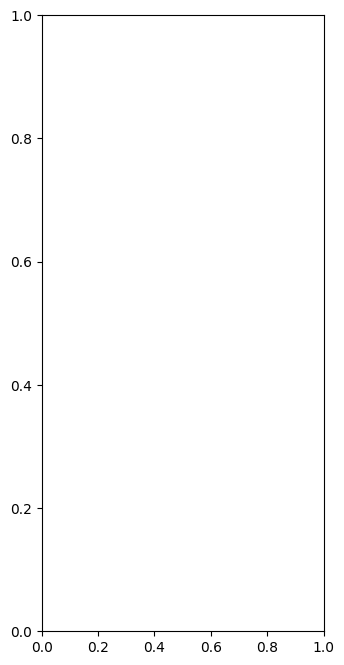

In [52]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Potato___Early_blight
1/1 [==============================] - 1s 994ms/step
predicted label: Potato___Early_blight


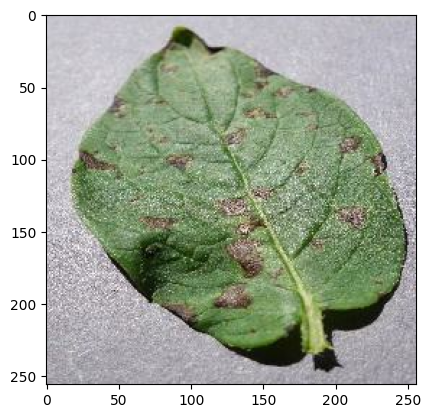

In [53]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [55]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 52ms/step


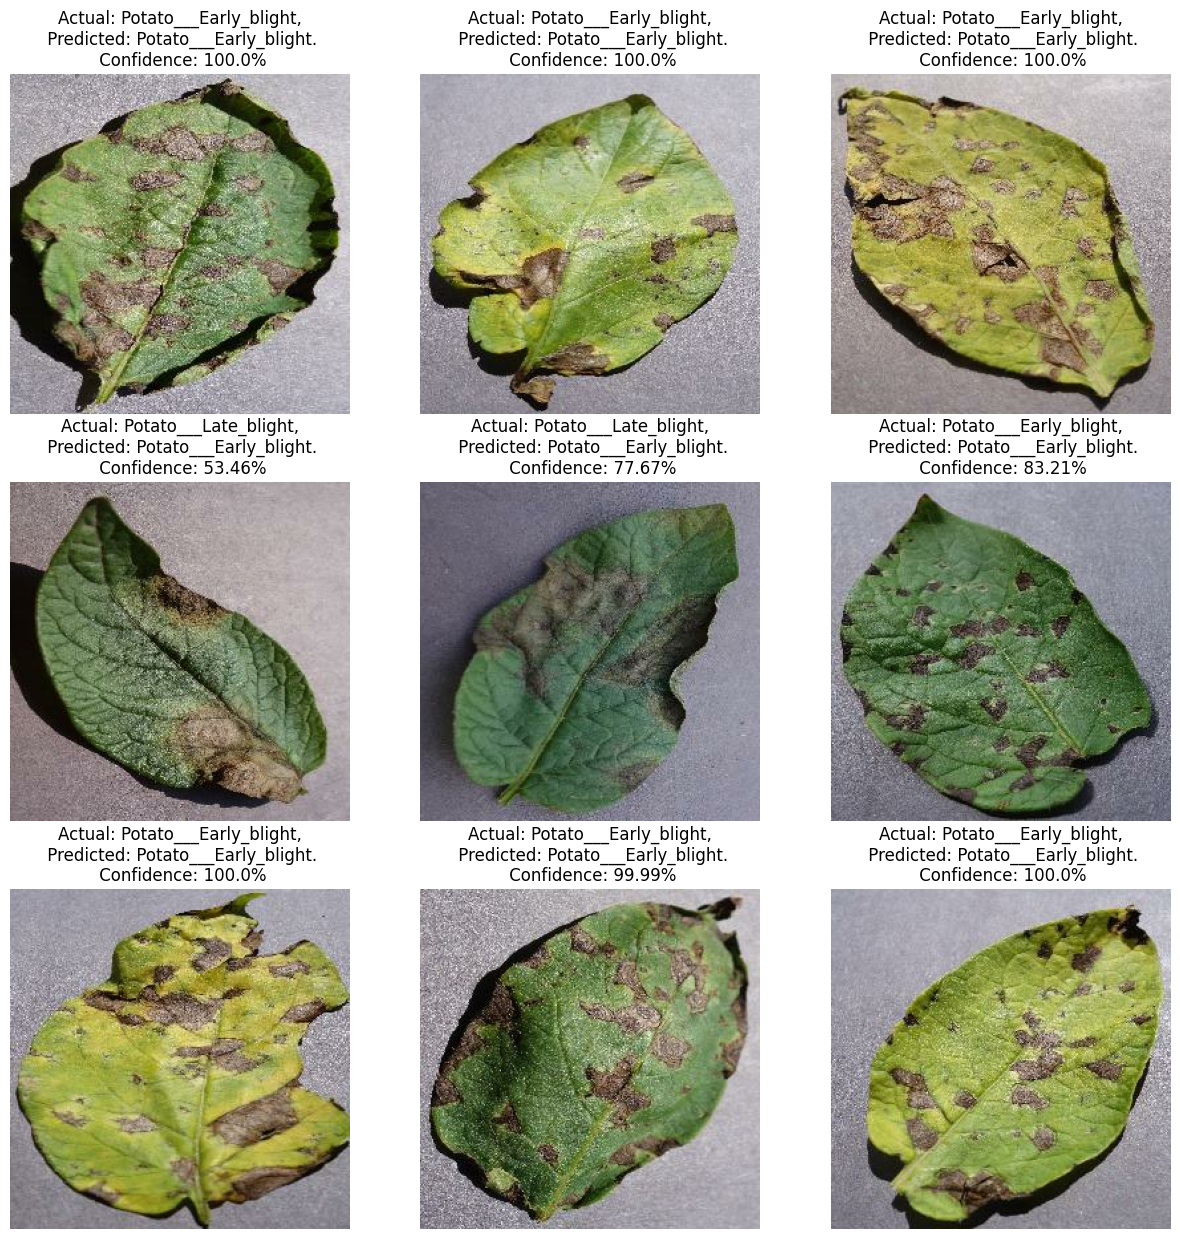

In [56]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [60]:
import os
model_version=max([int(i) for i in os.listdir("../models") + [0]])+1
model.save(f"../model/{model_version}")

INFO:tensorflow:Assets written to: ../model/1\assets


INFO:tensorflow:Assets written to: ../model/1\assets
